# Imaging systematic mitigation on mock

**author:** Edmond Chaussidon (CEA Saclay)

**mail:** edmond.chaussidon@cea.fr

This notebook explains how to mitigate photometric systematics on mock or a catalog of objetcs.

In [1]:
import os
import logging

import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

from regressis import PhotometricDataFrame, Regression, DR9Footprint
from regressis.utils import setup_logging, setup_mplstyle, build_healpix_map
from regressis.plot import plot_moll

In [2]:
logger = logging.getLogger('Notebook')
setup_logging()

# On NERSC, you may need to load tex with `module load texlive`
# With you don't want please comment the following line
setup_mplstyle()

## 1. Create data:

In [3]:
def generate_catalog(nsample, radecbox=None):
    # uniform along theta and phi 
    # not along R.A. and Dec. !
    ran1, ran2 = np.random.random(2*nsample).reshape(2, -1)

    ra  = np.degrees(2*np.pi * (ran1 - 0.5))
    dec = np.degrees(np.arcsin(2.*(ran2-0.5)))
    
    if radecbox is not None:
        ra_min, ra_max, dec_min, dec_max = radecbox
        sel = (ra_min < ra) & (ra_max > ra) & (dec_min < dec) & (dec_max > dec)
        ra, dec = ra[sel], dec[sel]
        
    return ra, dec

In [4]:
# genrate uniform data and corresponding randoms.
nsample = int(1e7)
radecbox = [120, 250, 20, 50]

data = generate_catalog(nsample, radecbox)
randoms = generate_catalog(nsample*10, radecbox)

#build corresponding healpix map:
nside = 256

data_map = build_healpix_map(nside, data[0], data[1], in_deg2=False)
randoms_map = build_healpix_map(nside, randoms[0], randoms[1], in_deg2=True)

sel = randoms_map > 0

fracarea = randoms_map / np.mean(randoms_map[sel])
fracarea[~sel] = np.NaN

In [5]:
version, tracer, suffix_tracer = 'MOCK', 'UNIFORM', ''

# Load DR9 footprint:
dr9_footprint = DR9Footprint(nside, mask_lmc=False, clear_south=True, mask_around_des=True, cut_desi=False)

# Set parameters for the dataframe:
params = dict()
params['data_dir'] = '../regressis/tests/test_case_qso'
params['output_dir'] = None
# use median since nside is a bit large here .. (if you want to use mean please increase the density)
params['use_median'] = True 
params['regions'] = ['North', 'South']

# Build PhotometricDataFrame class:
dataframe = PhotometricDataFrame(version, tracer, dr9_footprint, suffix_tracer, **params)

# Load features from params['data_dir']:
logger.info('Features')
dataframe.set_features() 

logger.info('Targets')
dataframe.set_targets(targets=data_map, fracarea=fracarea)

logger.info('Build')
dataframe.build(cut_fracarea=False)

[000008.98] 22-01-07 15:50  Footprint            INFO     Load DR9 footprint with mask_lmc=False, clear_south=True, mask_around_des=True and cut_desi=False
[000009.02] 22-01-07 15:50  DataFrame            INFO     version: MOCK -- tracer: UNIFORM -- regions: ['North', 'South']
[000009.02] 22-01-07 15:50  Notebook             INFO     Features
[000009.02] 22-01-07 15:50  DataFrame            INFO     Read ../regressis/tests/test_case_qso/pixweight-dr9-256.fits
[000009.36] 22-01-07 15:50  DataFrame            INFO     Read ../regressis/tests/test_case_qso/sagittarius_stream_256.npy
[000009.41] 22-01-07 15:50  DataFrame            INFO     Sanity check: number of NaNs in features: 0
[000009.43] 22-01-07 15:50  Notebook             INFO     Targets
[000009.43] 22-01-07 15:50  Notebook             INFO     Build


/Users/ec263193/Documents/CEA/Software/regressis/regressis/dataframe.py:207: RuntimeWarning: invalid value encountered in greater
  considered_footprint = (self.fracarea > 0) & (self.targets > 0) & self.footprint('footprint')


[000010.15] 22-01-07 15:50  DataFrame            INFO     The considered footprint represents 7.52% of the DR9 footprint
[000010.15] 22-01-07 15:50  DataFrame            INFO     They are 0 pixels which will be not used for the training i.e. 0.00% of the considered footprint
[000011.22] 22-01-07 15:50  DataFrame            INFO       ** North: 12.44 -- 1.0221 -- 1.0221
[000012.74] 22-01-07 15:50  DataFrame            INFO       ** South: 12.35 -- 1.0247 -- 1.0247


In [6]:
# Which features will be used during the regression. 
feature_names = ['STARDENS', 'EBV',
                 'PSFDEPTH_G', 'PSFDEPTH_R', 'PSFDEPTH_Z',
                 'PSFSIZE_G', 'PSFSIZE_R', 'PSFSIZE_Z']

# Use kfold training/eval to avoid overfitting !!
use_kfold = False

regression = Regression(dataframe, feature_names=feature_names,
                        regressor='LINEAR', suffix_regressor='', use_kfold=use_kfold,
                        n_jobs=6, seed=123)

[000012.75] 22-01-07 15:50  Regression           INFO     We use the set of features: ['STARDENS', 'EBV', 'PSFDEPTH_G', 'PSFDEPTH_R', 'PSFDEPTH_Z', 'PSFSIZE_G', 'PSFSIZE_R', 'PSFSIZE_Z']
[000012.75] 22-01-07 15:50  Regression           WARNING  k-fold training not used
[000013.93] 22-01-07 15:50  Regression           INFO       ** North :
[000013.96] 22-01-07 15:50  Regression           INFO         --> Sample size North: 15456 -- Total sample size: 28126 -- Training fraction: 54.95%
[000013.96] 22-01-07 15:50  Regression           INFO         --> Use k-fold training ? False
[000013.96] 22-01-07 15:50  Regression           INFO         --> Engine: LINEAR with params: {}
[000013.96] 22-01-07 15:50  Regression           INFO               --> All features (except the STREAM) are normalized and centered on the training footprint
[000014.04] 22-01-07 15:50  Regression           INFO               --> Mean of mean and std on the fold-training features: -0.0000 -- 1.00
[000014.04] 22-01-07 

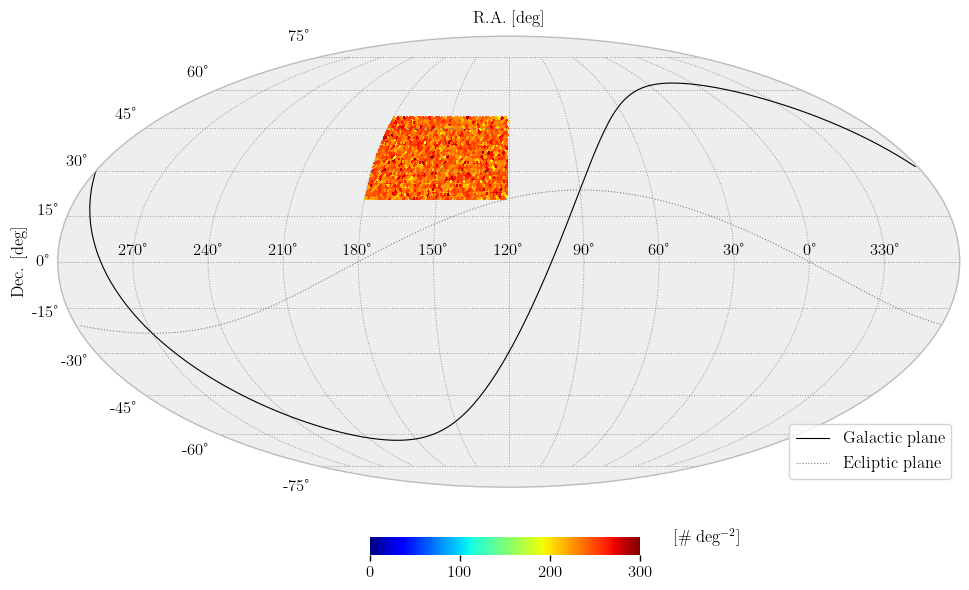

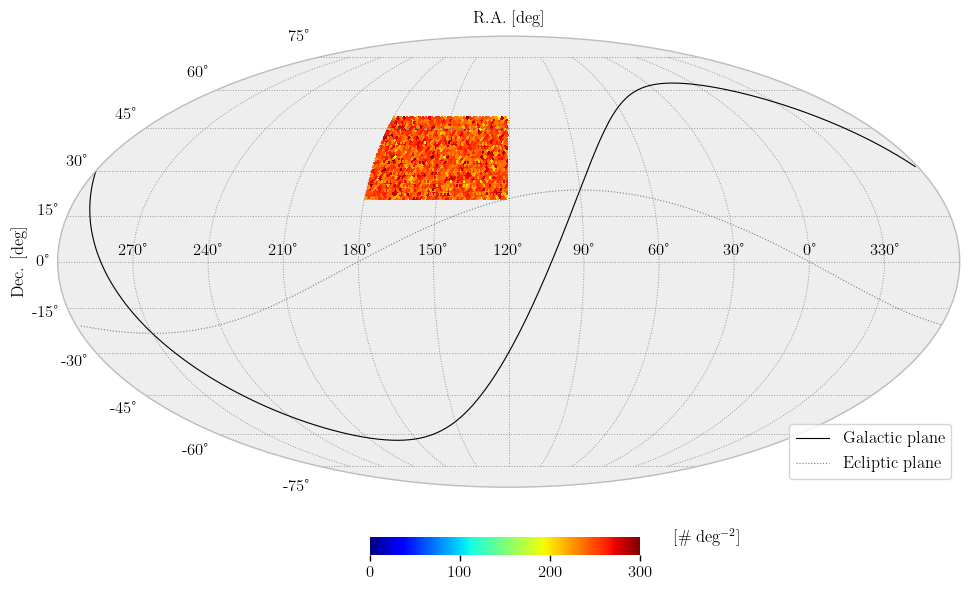

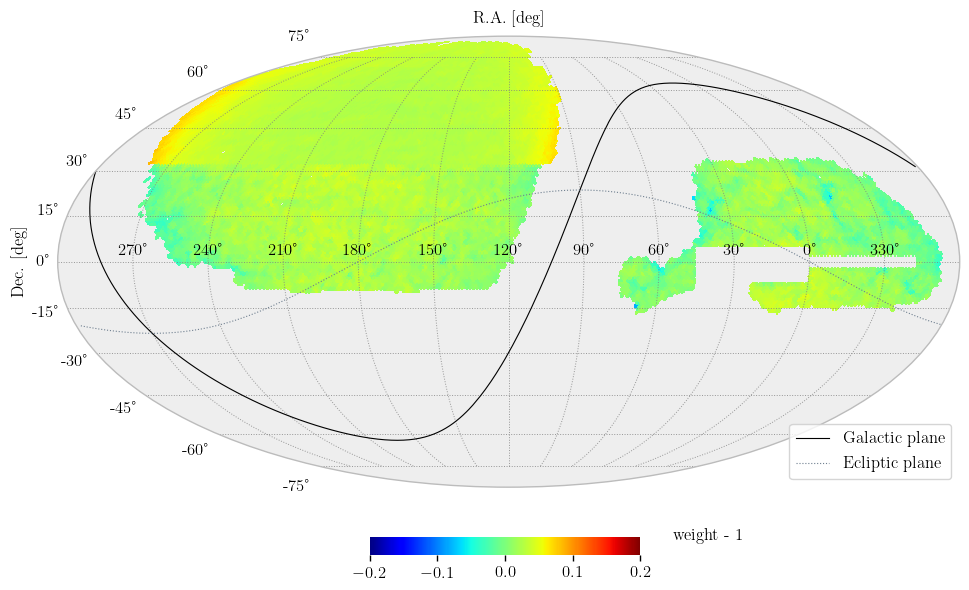

[000024.88] 22-01-07 15:50  Systematics          INFO     Work with North
[000026.42] 22-01-07 15:50  Systematics          INFO     Keep only pixels with fracarea > 0


/Users/ec263193/Documents/CEA/Software/regressis/regressis/systematics.py:147: RuntimeWarning: invalid value encountered in greater
  pix_to_keep &= (fracarea > 0)


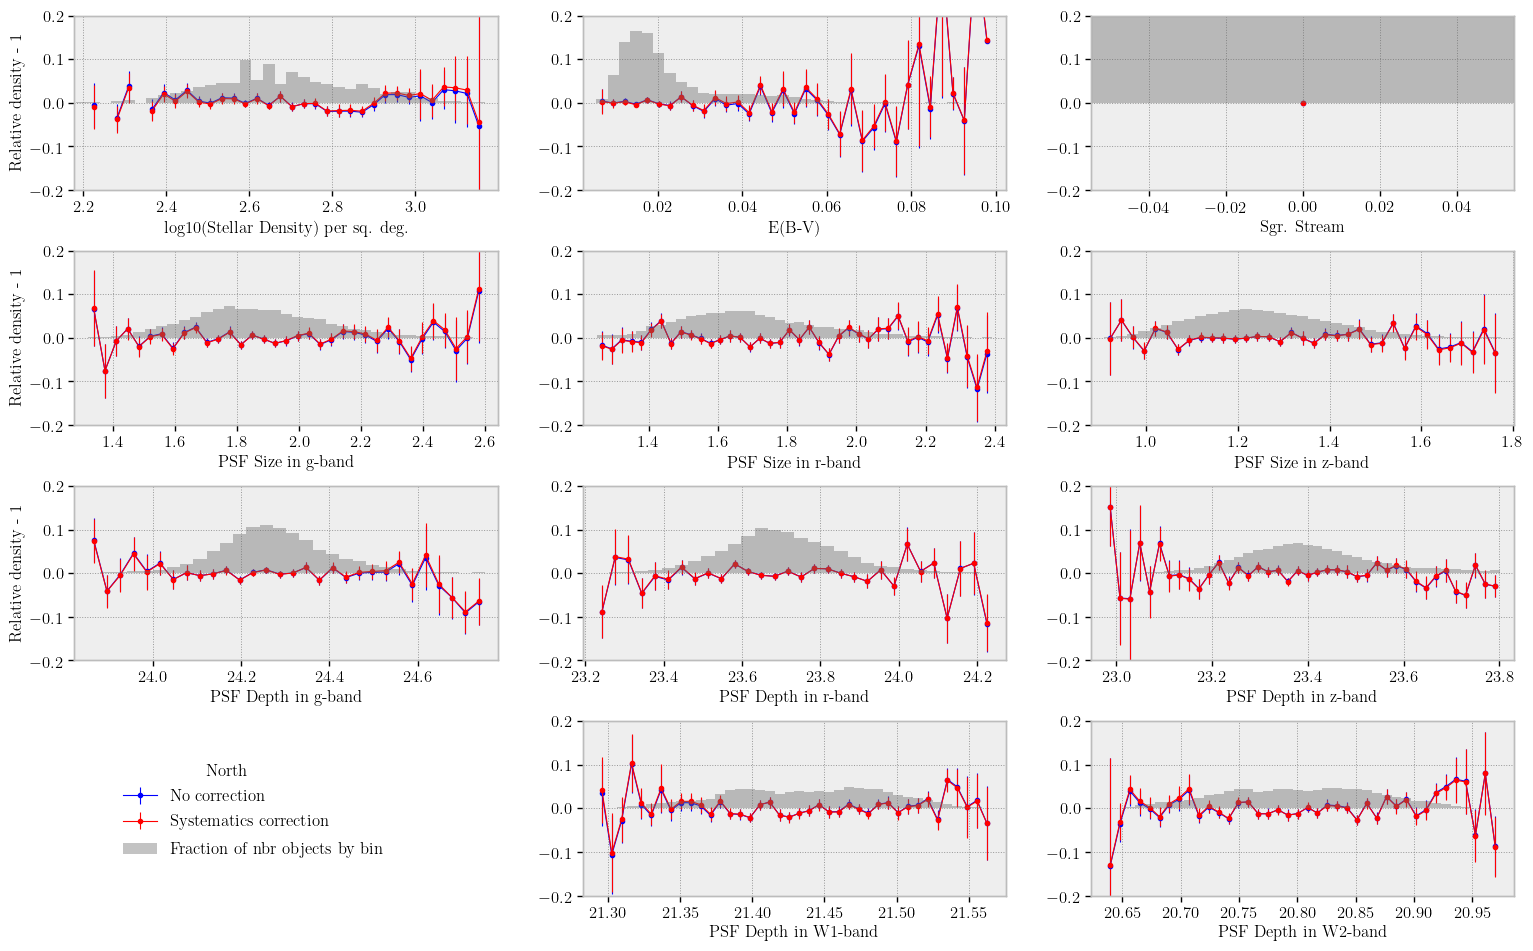

[000029.38] 22-01-07 15:50  Systematics          INFO     Work with South
[000030.65] 22-01-07 15:50  Systematics          INFO     Keep only pixels with fracarea > 0


/Users/ec263193/Documents/CEA/Software/regressis/regressis/systematics.py:147: RuntimeWarning: invalid value encountered in greater
  pix_to_keep &= (fracarea > 0)


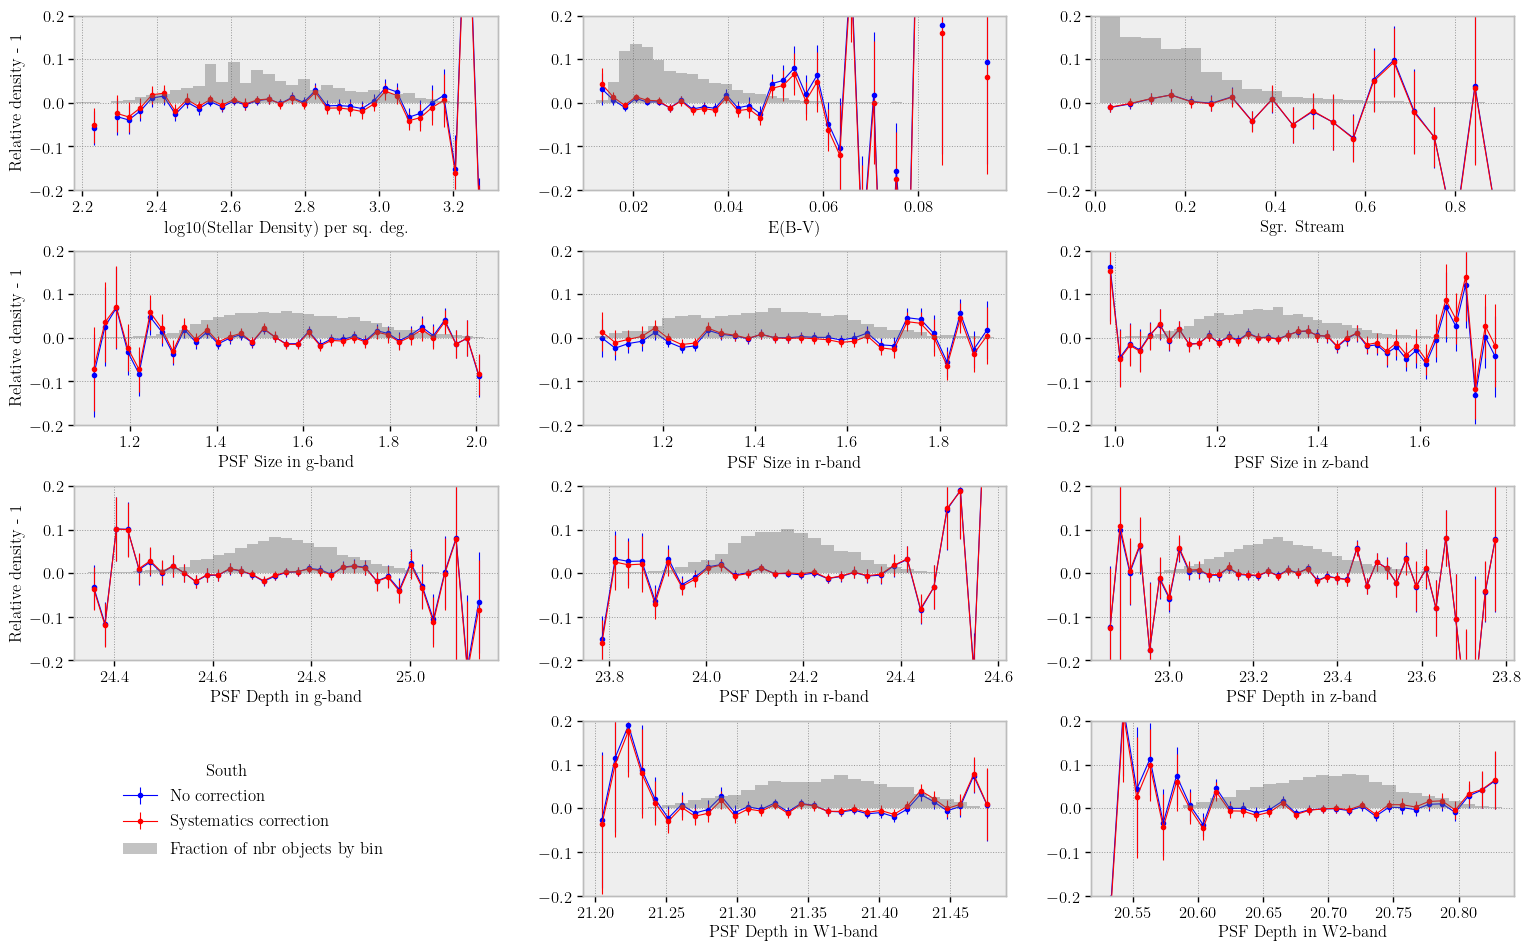

In [7]:
# Can also used pre-defined functions from regression class:

regression.plot_maps_and_systematics(max_plot_cart=300, cut_fracarea=False, show=True, save=False)